100.0%┣██████████████████████████████████████████┫ 1/1 [00:00<Inf:Inf, 0.0 it/s]
┌ Warning: `DataFrame(columns::AbstractMatrix)` is deprecated, use `DataFrame(columns, :auto)` instead.
│   caller = #generate#1(::Int64, ::Function, ::Main.Ntl.Models.Mixture{Main.Ntl.Models.NtlParameters{Main.Ntl.Models.GeometricArrivals},Main.Ntl.Models.FiniteTopicModelParameters}) at synthetic.jl:278
└ @ Main.Ntl.Generate /Users/seanla/Projects/ntl-stick-breaking-julia/src/synthetic.jl:278
┌ Warning: `DataFrame(columns::AbstractMatrix)` is deprecated, use `DataFrame(columns, :auto)` instead.
│   caller = #generate#1(::Int64, ::Function, ::Main.Ntl.Models.Mixture{Main.Ntl.Models.NtlParameters{Main.Ntl.Models.GeometricArrivals},Main.Ntl.Models.FiniteTopicModelParameters}) at synthetic.jl:280
└ @ Main.Ntl.Generate /Users/seanla/Projects/ntl-stick-breaking-julia/src/synthetic.jl:280


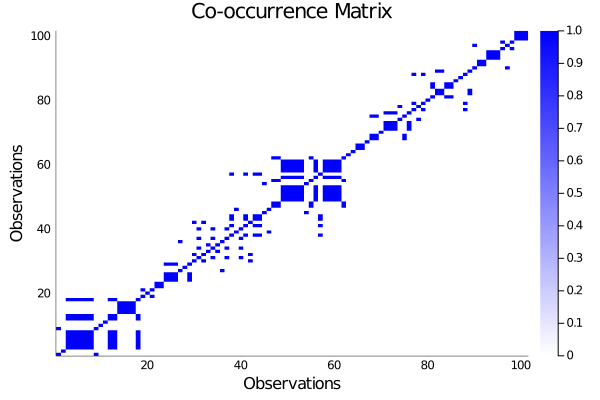

In [25]:
include("../ntl.jl")
import Random

using LinearAlgebra
Random.seed!(1)

data_parameters = Ntl.Models.FiniteTopicModelParameters(num_topics=10, num_words=100, length=10, topic_parameter=0.01, word_parameter=0.1)

psi_prior = Vector{Float64}([1, 1])
phi_prior = Vector{Float64}([1, 1])
geometric_arrival = Ntl.Models.GeometricArrivals(phi_prior)
ntl_cluster_parameters = Ntl.Models.NtlParameters(psi_prior, geometric_arrival)

mixture_model = Ntl.Models.Mixture(ntl_cluster_parameters, data_parameters)
n = 100
mixture = Ntl.Generate.generate(mixture_model, n=n+1)
data = Matrix(transpose(mixture[:, 2:end]))
training_data = data[:, 1:n]
test_datum = vec(data[:, n+1])
true_clustering = mixture[:, 1]
Ntl.Plot.plot_assignments(true_clustering)
Ntl.Plot.plot_co_occurrence_matrix(true_clustering)

100.0%┣███████████████████████████████████┫ 10999/10999 [02:24<00:00, 76.3 it/s]
100.0%┣███████████████████████████████████┫ 1000/1000 [00:01<00:00, 1816.9 it/s]


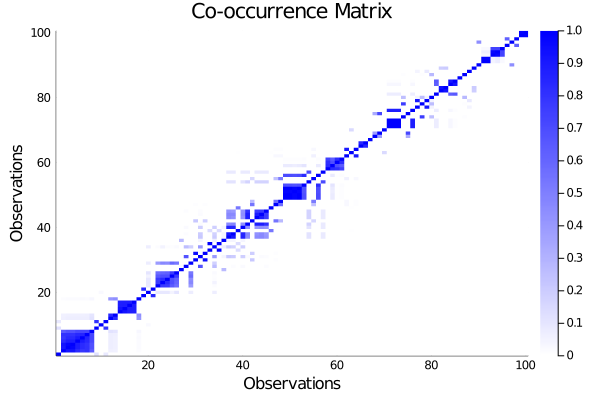

In [26]:
metropolis_hastings_sampler = Ntl.Samplers.MetropolisHastingsSampler(num_iterations=1000, num_burn_in=10000, cluster_radius=100, observation_window=100)
(metropolis_hastings_instances, log_likelihoods) = Ntl.Fitter.fit(training_data, mixture_model, metropolis_hastings_sampler) 
Ntl.Plot.plot_co_occurrence_matrix(metropolis_hastings_instances)